In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('../data/bank_transactions_data_2.csv')

# About Dataset

This dataset provides a detailed look into transactional behavior and financial activity patterns, ideal for exploring fraud detection and anomaly identification. It contains 2,512 samples of transaction data, covering various transaction attributes, customer demographics, and usage patterns. Each entry offers comprehensive insights into transaction behavior, enabling analysis for financial security and fraud detection applications.

Key Features:

- TransactionID: Unique alphanumeric identifier for each transaction.
- AccountID: Unique identifier for each account, with multiple transactions per account.
- TransactionAmount: Monetary value of each transaction, ranging from small everyday expenses to larger purchases.
- TransactionDate: Timestamp of each transaction, capturing date and time.
- TransactionType: Categorical field indicating 'Credit' or 'Debit' transactions.
- Location: Geographic location of the transaction, represented by U.S. city names.
- DeviceID: Alphanumeric identifier for devices used to perform the transaction.
- IP Address: IPv4 address associated with the transaction, with occasional changes for some accounts.
- MerchantID: Unique identifier for merchants, showing preferred and outlier merchants for each account.
- AccountBalance: Balance in the account post-transaction, with logical correlations based on transaction type and amount.
- PreviousTransactionDate: Timestamp of the last transaction for the account, aiding in calculating transaction frequency.
- Channel: Channel through which the transaction was performed (e.g., Online, ATM, Branch).
- CustomerAge: Age of the account holder, with logical groupings based on occupation.
- CustomerOccupation: Occupation of the account holder (e.g., Doctor, Engineer, Student, Retired), reflecting income patterns.
- TransactionDuration: Duration of the transaction in seconds, varying by transaction type.
- LoginAttempts: Number of login attempts before the transaction, with higher values indicating potential anomalies.

This dataset is ideal for data scientists, financial analysts, and researchers looking to analyze transactional patterns, detect fraud, and build predictive models for financial security applications. The dataset was designed for machine learning and pattern analysis tasks and is not intended as a primary data source for academic publications.

In [4]:
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [5]:
df.describe()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance
count,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000
mean,297.593778,44.673965,119.643312,1.124602,5114.302966
std,291.946243,17.792198,69.963757,0.602662,3900.942499
min,0.260000,18.000000,10.000000,1.000000,101.250000
25%,81.885000,27.000000,63.000000,1.000000,1504.370000
50%,211.140000,45.000000,112.500000,1.000000,4735.510000
75%,414.527500,59.000000,161.000000,1.000000,7678.820000
max,1919.110000,80.000000,300.000000,5.000000,14977.990000


In [6]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])

# Feature Engineering

In [7]:
# # Velocity (Time since last transaction in minutes)
# # Logic: Rapid-fire transactions are classic bot behavior
# df['TimeSinceLast'] = (df['TransactionDate'] - df['PreviousTransactionDate']).dt.total_seconds() / 60

In [8]:
df[df['TransactionDate'] > df['PreviousTransactionDate']]

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate


Dataset bug cant use prevtransdate column

In [9]:
# Feature: Device Integrity (Count of unique Accounts per Device)
device_map = df.groupby('DeviceID')['AccountID'].nunique().reset_index()
device_map.columns = ['DeviceID', 'UniqueAccountsLinked']

df = df.merge(device_map, on='DeviceID', how='left')

In [10]:
device_map[device_map['UniqueAccountsLinked'] > 3]

,DeviceID,UniqueAccountsLinked
0,D000001,4
1,D000002,5
3,D000004,4
4,D000005,6
5,D000006,4
...,...,...
667,D000687,4
670,D000690,6
673,D000693,4
677,D000697,9


In [11]:
ip_map = df.groupby('IP Address')['AccountID'].nunique().reset_index()
ip_map.columns = ['IP Address', 'UniqueAccountsIP']

df = df.merge(ip_map, on='IP Address', how='left')

In [12]:
# Balance Impact (Ratio of transaction to current balance)
# Logic: Draining an account (high ratio) is a fraud signal
df['AmounttoBalanceRatio'] = df['TransactionAmount'] / df['AccountBalance']

In [13]:
# Group by Occupation to find the "Normal" range for each job
occupation_stats = df.groupby('CustomerOccupation')['AccountBalance'].agg(['mean', 'std']).reset_index()
occupation_stats.columns = ['CustomerOccupation', 'OccMean', 'OccStd']

df = df.merge(occupation_stats, on='CustomerOccupation', how='left')

In [14]:
df['BalanceOccZScore'] = (df['AccountBalance'] - df['OccMean']) / df['OccStd']
df['BalanceOccZScore'] = df['BalanceOccZScore'].fillna(0)

In [15]:
df['Hour'] = df['TransactionDate'].dt.hour
df['DayOfWeek'] = df['TransactionDate'].dt.day_name()

In [16]:
df.sample(10)

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,UniqueAccountsLinked,UniqueAccountsIP,AmounttoBalanceRatio,OccMean,OccStd,BalanceOccZScore,Hour,DayOfWeek
2439,TX002440,AC00439,538.17,2023-09-26 17:27:17,Credit,Washington,D000430,116.44.12.250,M055,Branch,27,Engineer,252,1,5908.04,2024-11-04 08:10:25,7,5,0.091091,5486.406064,2755.228128,0.153030,17,Tuesday
762,TX000763,AC00165,820.62,2023-03-03 17:18:59,Credit,Fresno,D000622,47.82.77.181,M084,Branch,61,Doctor,158,1,6024.80,2024-11-04 08:07:28,6,8,0.136207,8978.994057,4106.588338,-0.719379,17,Friday
1424,TX001425,AC00179,360.02,2023-02-09 16:29:06,Debit,Dallas,D000072,49.31.186.82,M004,Online,68,Retired,68,1,6400.59,2024-11-04 08:08:53,6,11,0.056248,4542.157012,2043.669165,0.909361,16,Thursday
448,TX000449,AC00093,70.23,2023-09-13 16:18:07,Debit,Memphis,D000293,146.47.189.38,M066,ATM,38,Doctor,260,1,11624.93,2024-11-04 08:07:16,3,2,0.006041,8978.994057,4106.588338,0.644315,16,Wednesday
1207,TX001208,AC00267,31.81,2023-04-06 17:41:53,Debit,Fort Worth,D000641,147.114.91.132,M033,Online,51,Retired,149,1,1406.60,2024-11-04 08:06:48,4,8,0.022615,4542.157012,2043.669165,-1.534278,17,Thursday
1560,TX001561,AC00362,111.66,2023-06-07 18:18:32,Credit,Washington,D000384,62.251.170.72,M068,Online,48,Engineer,140,1,5716.72,2024-11-04 08:07:36,6,3,0.019532,5486.406064,2755.228128,0.083592,18,Wednesday
637,TX000638,AC00026,90.88,2023-02-20 16:48:49,Debit,Albuquerque,D000449,196.244.194.198,M071,Branch,18,Student,176,1,3908.47,2024-11-04 08:07:13,5,5,0.023252,1570.209985,1909.701908,1.224411,16,Monday
1300,TX001301,AC00372,836.45,2023-02-27 16:02:00,Debit,Virginia Beach,D000096,156.134.123.253,M043,Online,61,Retired,63,1,1731.89,2024-11-04 08:12:12,4,4,0.482969,4542.157012,2043.669165,-1.375109,16,Monday
357,TX000358,AC00459,374.50,2023-07-24 16:45:31,Credit,San Francisco,D000045,9.230.41.239,M002,Branch,26,Student,178,1,1671.51,2024-11-04 08:08:37,5,10,0.224049,1570.209985,1909.701908,0.053045,16,Monday
1635,TX001636,AC00465,40.12,2023-04-19 17:03:11,Credit,Dallas,D000203,44.73.3.217,M016,ATM,36,Doctor,269,1,14304.38,2024-11-04 08:10:40,9,5,0.002805,8978.994057,4106.588338,1.296791,17,Wednesday


# EDA

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TransactionID            2512 non-null   object        
 1   AccountID                2512 non-null   object        
 2   TransactionAmount        2512 non-null   float64       
 3   TransactionDate          2512 non-null   datetime64[ns]
 4   TransactionType          2512 non-null   object        
 5   Location                 2512 non-null   object        
 6   DeviceID                 2512 non-null   object        
 7   IP Address               2512 non-null   object        
 8   MerchantID               2512 non-null   object        
 9   Channel                  2512 non-null   object        
 10  CustomerAge              2512 non-null   int64         
 11  CustomerOccupation       2512 non-null   object        
 12  TransactionDuration      2512 non-

In [18]:
sns.set_theme(style="whitegrid", palette="muted")

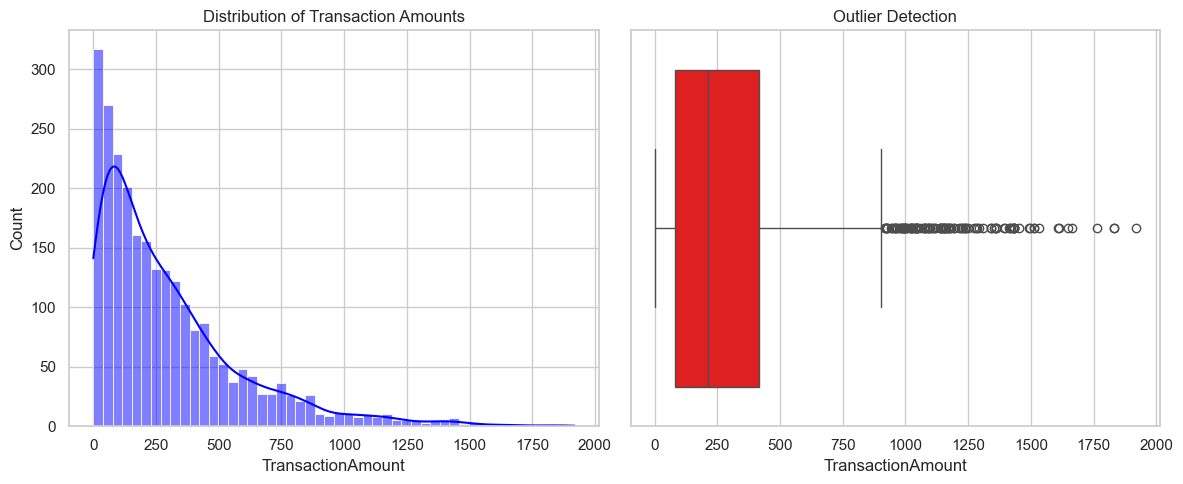

In [19]:
# 1. Distribution of Transaction Amounts
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['TransactionAmount'], bins=50, kde=True, color='blue')
plt.title('Distribution of Transaction Amounts')
plt.subplot(1, 2, 2)
sns.boxplot(x=df['TransactionAmount'], color='red')
plt.title('Outlier Detection')
plt.tight_layout()
plt.show()

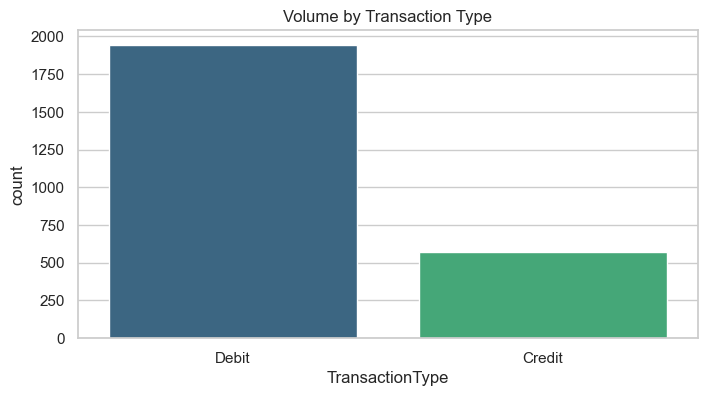

In [20]:
# 2. Transaction Type Analysis
plt.figure(figsize=(8, 4))
sns.countplot(x='TransactionType', data=df, palette='viridis', hue='TransactionType', legend=False)
plt.title('Volume by Transaction Type')
plt.show()

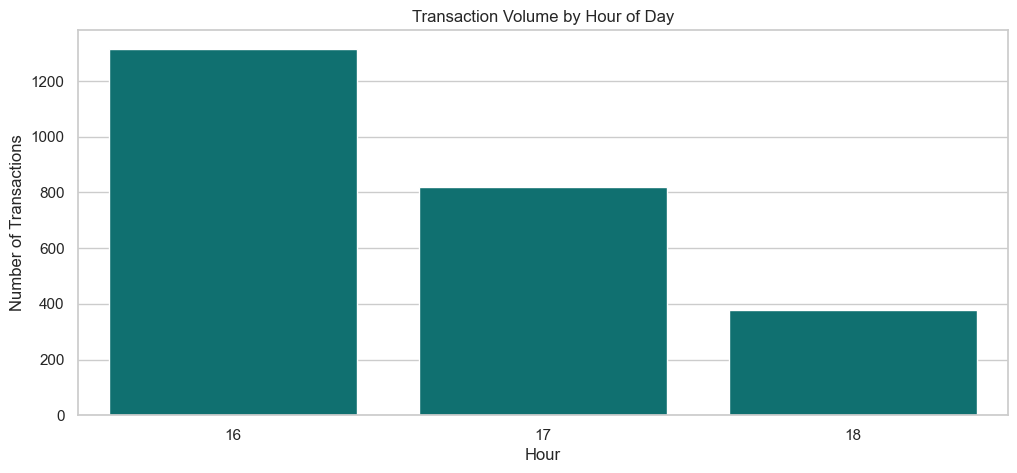

In [21]:
# 3. Temporal Analysis (When is fraud likely?)
plt.figure(figsize=(12, 5))
sns.countplot(x='Hour', data=df, color='teal')
plt.title('Transaction Volume by Hour of Day')
plt.ylabel('Number of Transactions')
plt.show()

In [22]:
# 4. High-Risk Logic: Duplicate IPs or Devices
# Check if single IP is used by multiple different accounts
print("--- IPs shared by multiple accounts ---")
# Filter for IPs used by more than 1 account to show the risk
suspicious_ips = df[df['UniqueAccountsIP'] > 1][['IP Address', 'UniqueAccountsIP']].drop_duplicates().sort_values(by='UniqueAccountsIP', ascending=False).head(10)
print(suspicious_ips)

--- IPs shared by multiple accounts ---
          IP Address  UniqueAccountsIP
387   200.136.146.93                13
756     49.31.186.82                11
43    173.135.78.201                10
189   147.119.62.178                10
62      9.230.41.239                10
561   166.79.195.157                10
38      49.29.37.185                 9
117    101.90.40.193                 9
110     77.7.223.184                 9
73   152.140.239.181                 9


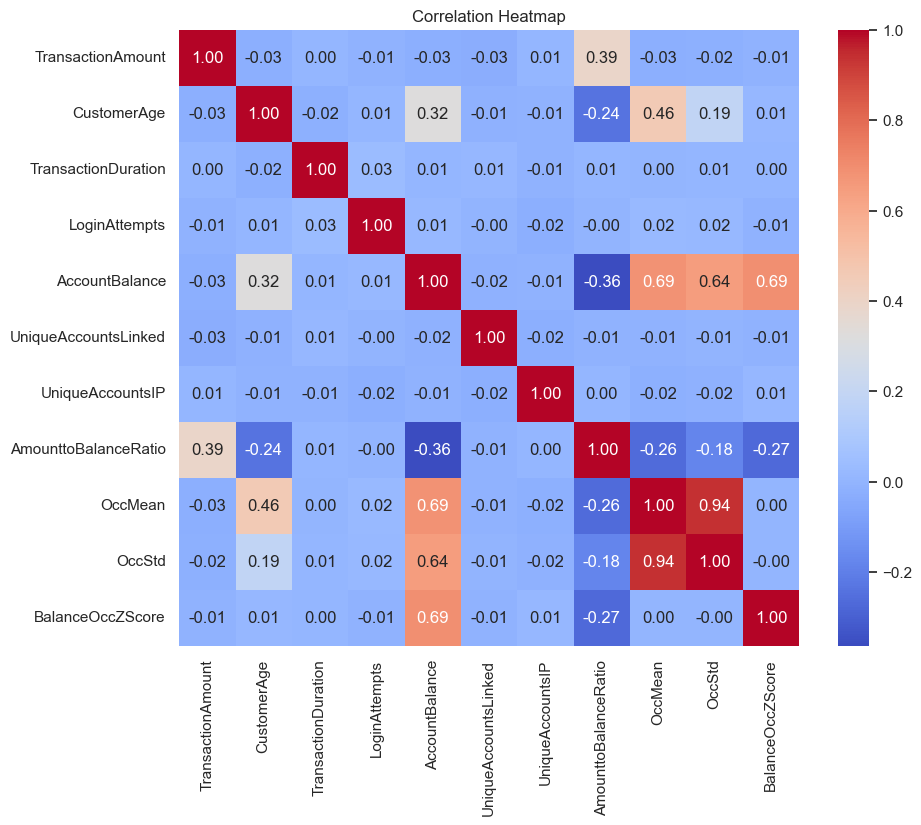

In [23]:
# 5. Correlation Matrix 
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

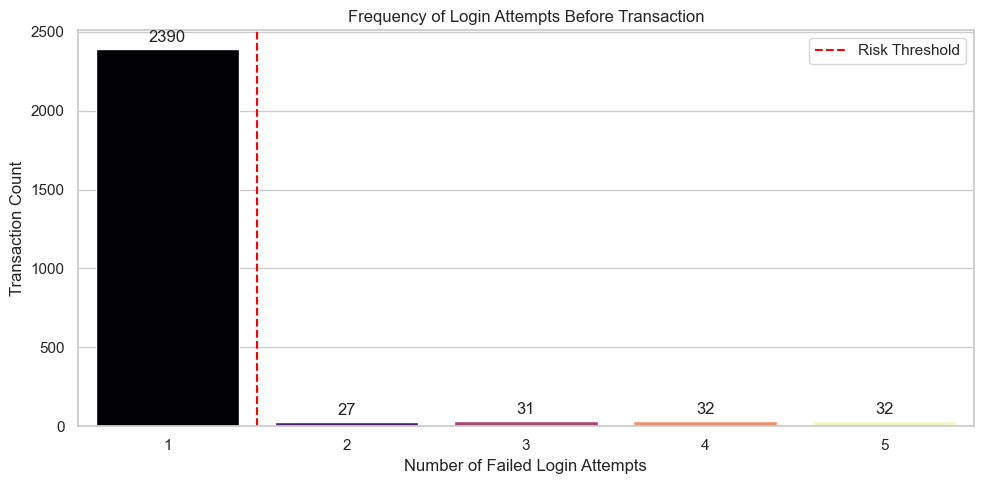

In [24]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="LoginAttempts", hue="LoginAttempts", legend=False, data=df, palette="magma")

for container in ax.containers:
    ax.bar_label(container, fmt="%d", label_type="edge", padding=3)

plt.title("Frequency of Login Attempts Before Transaction")
plt.xlabel("Number of Failed Login Attempts")
plt.ylabel("Transaction Count")
plt.axvline(x=0.5, color="red", linestyle="--", label="Risk Threshold")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# High Login Attempts
brute_force = df[df['LoginAttempts'] > 2]
print(f"Potential Account Takeover (> 2 login attempts): {len(brute_force)} transactions detected.")
brute_force.sort_values(by="LoginAttempts", ascending=False).head(10)

Potential Account Takeover (> 2 login attempts): 95 transactions detected.


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,UniqueAccountsLinked,UniqueAccountsIP,AmounttoBalanceRatio,OccMean,OccStd,BalanceOccZScore,Hour,DayOfWeek
26,TX000027,AC00441,246.93,2023-04-17 16:37:01,Debit,Miami,D000046,55.154.161.250,M029,ATM,23,Student,158,5,673.35,2024-11-04 08:11:38,8,5,0.366719,1570.209985,1909.701908,-0.469633,16,Monday
147,TX000148,AC00161,514.95,2023-04-13 18:37:48,Debit,New York,D000109,23.92.205.75,M056,Online,41,Doctor,142,5,421.93,2024-11-04 08:10:01,3,5,1.220463,8978.994057,4106.588338,-2.083740,18,Thursday
274,TX000275,AC00454,1176.28,2023-12-20 16:08:02,Credit,Kansas City,D000476,50.202.8.53,M074,ATM,54,Engineer,174,5,323.69,2024-11-04 08:11:44,4,4,3.633971,5486.406064,2755.228128,-1.873789,16,Wednesday
414,TX000415,AC00495,83.50,2023-05-15 18:47:35,Debit,Dallas,D000446,34.92.221.183,M100,Branch,61,Retired,91,5,1749.79,2024-11-04 08:07:22,3,3,0.047720,4542.157012,2043.669165,-1.366350,18,Monday
463,TX000464,AC00417,302.16,2023-10-18 17:47:52,Debit,Kansas City,D000123,84.237.126.96,M014,Online,80,Retired,138,5,3876.61,2024-11-04 08:07:38,3,4,0.077944,4542.157012,2043.669165,-0.325663,17,Wednesday
394,TX000395,AC00326,6.30,2023-12-14 18:52:54,Debit,Columbus,D000539,210.160.90.52,M017,Branch,80,Retired,283,5,7697.68,2024-11-04 08:12:13,4,4,0.000818,4542.157012,2043.669165,1.544048,18,Thursday
491,TX000492,AC00318,505.19,2023-03-14 16:25:04,Debit,Kansas City,D000660,60.89.202.192,M023,ATM,30,Doctor,128,5,5326.68,2024-11-04 08:10:19,4,7,0.094841,8978.994057,4106.588338,-0.889379,16,Tuesday
691,TX000692,AC00418,25.94,2023-10-16 18:53:31,Credit,San Jose,D000232,42.219.228.159,M003,Online,58,Retired,211,5,4815.11,2024-11-04 08:06:38,7,6,0.005387,4542.157012,2043.669165,0.133560,18,Monday
685,TX000686,AC00071,119.30,2023-08-28 16:08:54,Debit,Mesa,D000597,90.111.245.138,M058,Branch,34,Engineer,22,5,319.04,2024-11-04 08:08:55,3,7,0.373934,5486.406064,2755.228128,-1.875477,16,Monday
792,TX000793,AC00468,253.55,2023-01-11 16:56:58,Debit,Jacksonville,D000112,41.82.55.163,M007,ATM,28,Engineer,85,5,2797.26,2024-11-04 08:09:12,6,7,0.090642,5486.406064,2755.228128,-0.976016,16,Wednesday


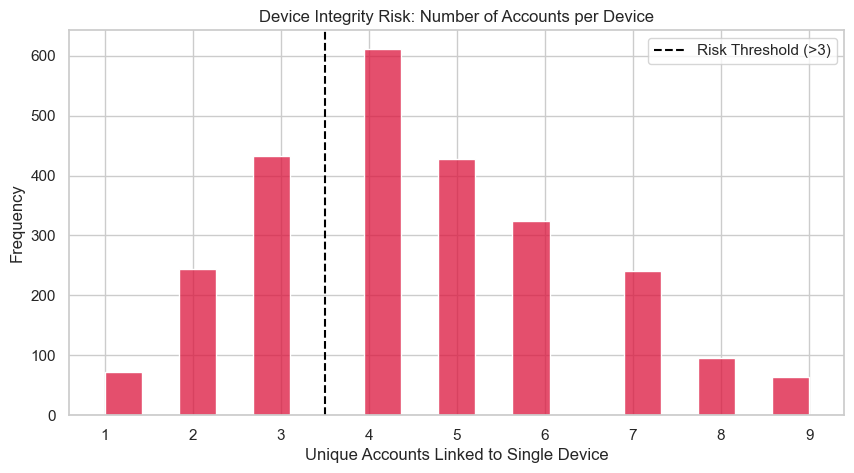

In [26]:
# --- VISUALIZATION ---
plt.figure(figsize=(10, 5))
sns.histplot(df['UniqueAccountsLinked'], color='crimson')
plt.title('Device Integrity Risk: Number of Accounts per Device')
plt.xlabel('Unique Accounts Linked to Single Device')
plt.ylabel('Frequency')
plt.axvline(x=3.5, color='black', linestyle='--', label='Risk Threshold (>3)')
plt.legend()
plt.show()

In [27]:
# --- Botnet Saturation Analysis (Isolated) ---

# 1. Calculate Device Linkage Stats (Does not modify original df)
device_linkage = df.groupby('DeviceID')['AccountID'].nunique()

# 2. Identify the list of "At-Risk" Device IDs
at_risk_device_ids = device_linkage[device_linkage > 3].index

# 3. Create a new, separate DataFrame for this analysis
botnet_analysis_df = df[df['DeviceID'].isin(at_risk_device_ids)].copy()

# 4. Perform analysis on the new DataFrame
naive_botnets = len(botnet_analysis_df)
true_botnets = len(botnet_analysis_df[botnet_analysis_df['Channel'] == 'Online'])
false_positives = naive_botnets - true_botnets

# 5. Print the findings
print(f"=== FORENSIC ANALYSIS: BOTNET SATURATION ===")
print(f"Total Transactions: {len(df)}")
print(f"   - Naive Count (All Shared Devices): {naive_botnets} ({naive_botnets/len(df):.2%})")
print(f"   - True Botnet Count (Online Only): {true_botnets} ({true_botnets/len(df):.2%})")
print(f"   - False Positives (ATMs/Branches) Removed: {false_positives}")

=== FORENSIC ANALYSIS: BOTNET SATURATION ===
Total Transactions: 2512
   - Naive Count (All Shared Devices): 1763 (70.18%)
   - True Botnet Count (Online Only): 556 (22.13%)
   - False Positives (ATMs/Branches) Removed: 1207


In [28]:
# Isolate the Fraud Ring segment (Devices used by > 3 different people)
suspicious_devices = df[(df['UniqueAccountsLinked'] > 3) & (df['Channel'] == "Online")]

In [29]:
print(f"Number of transactions linked to multi-user devices (>3 accounts): {suspicious_devices['DeviceID'].nunique()}")
print(f"Top suspicious devices:\n{suspicious_devices['DeviceID'].value_counts().head(10)}")

Number of transactions linked to multi-user devices (>3 accounts): 288
Top suspicious devices:
DeviceID
D000451    7
D000377    6
D000686    5
D000697    5
D000484    5
D000255    5
D000129    4
D000413    4
D000211    4
D000682    4
Name: count, dtype: int64


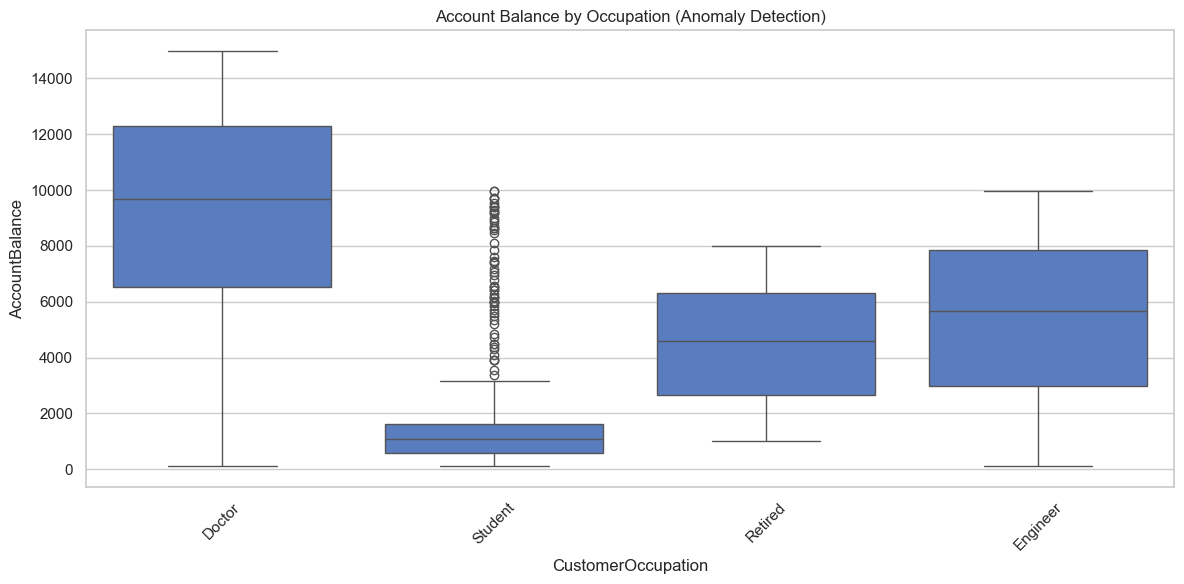

In [30]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='CustomerOccupation', y='AccountBalance', data=df)
plt.xticks(rotation=45)
plt.title('Account Balance by Occupation (Anomaly Detection)')
plt.tight_layout()
plt.show()

In [31]:
zscore = df[df['BalanceOccZScore'] > 3]
print(f"Potential Account Balance Anomalies (> 3 Z-Score): {len(zscore)} transactions detected.")

df[df['BalanceOccZScore'] > 3][['AccountID', 'CustomerOccupation', 'BalanceOccZScore']].drop_duplicates().sort_values(by='BalanceOccZScore', ascending=False).head(10)

Potential Account Balance Anomalies (> 3 Z-Score): 27 transactions detected.


,AccountID,CustomerOccupation,BalanceOccZScore
1984,AC00303,Student,4.395021
1138,AC00020,Student,4.388889
840,AC00065,Student,4.265833
2362,AC00003,Student,4.257570
1230,AC00373,Student,4.254502
294,AC00148,Student,4.169347
2342,AC00420,Student,4.114176
101,AC00018,Student,4.091330
683,AC00242,Student,4.089287
2474,AC00302,Student,4.046333


In [32]:
# df[(df['CustomerOccupation'] == "Doctor") & (df['final_status'] == 'Potential Fraud (ML)')].head(10)

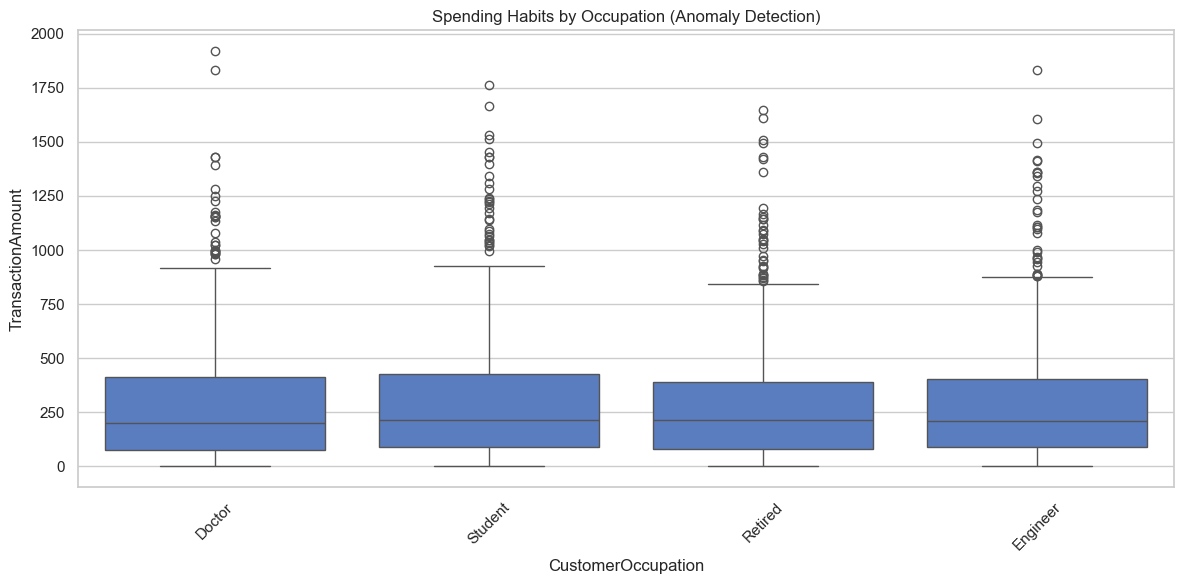

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='CustomerOccupation', y='TransactionAmount', data=df)
plt.xticks(rotation=45)
plt.title('Spending Habits by Occupation (Anomaly Detection)')
plt.tight_layout()
plt.show()

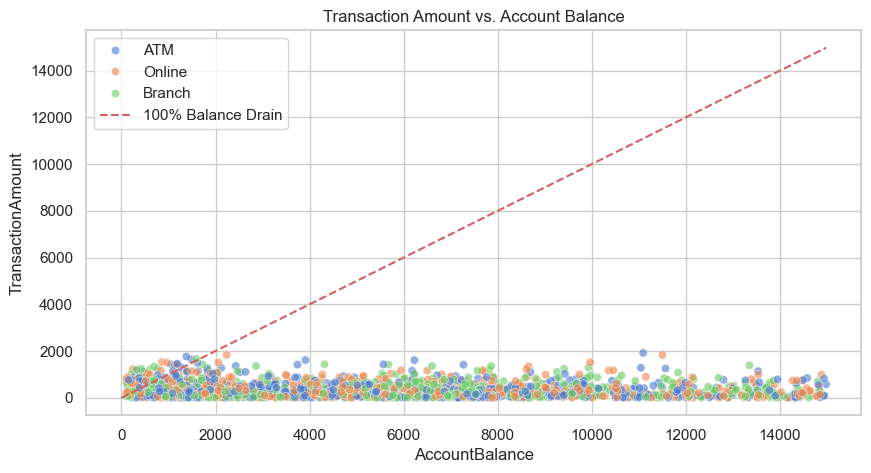

In [34]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='AccountBalance', y='TransactionAmount', hue='Channel', data=df, alpha=0.6)
plt.title('Transaction Amount vs. Account Balance')
plt.plot([0, df['AccountBalance'].max()], [0, df['AccountBalance'].max()], 'r--', label='100% Balance Drain')
plt.legend()
plt.show()

# Model Building

In [35]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import joblib

# We define a 'Ring' as any device/IP used by > 3 unique accounts
df["is_rule_fail"] = (df["Channel"] == "Online") & (df["UniqueAccountsLinked"] > 3) | (
    df["UniqueAccountsIP"] > 3
)

# We only want the ML to look at features that aren't covered by the rules
ml_features = [
    "TransactionAmount",
    "LoginAttempts",
    "AmounttoBalanceRatio",
    "BalanceOccZScore",
    # "UniqueAccountsLinked",
    # "UniqueAccountsIP",
]
X = df[ml_features].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.10, random_state=42)
model.fit(X_scaled)

# Logic: If it breaks the Rule, it's Fraud (-1).
#        If it passes the Rule, ask the ML Model.
df["ml_pred"] = model.predict(X_scaled)


def hybrid_decision(row):
    if row["is_rule_fail"]:
        return "Potential Fraud (Rule)"
    elif row["ml_pred"] == -1:
        return "Potential Fraud (ML)"
    else:
        return "Normal"


df["final_status"] = df.apply(hybrid_decision, axis=1)

print("=== ML MODEL SYSTEM PERFORMANCE ===")
display(
    df.groupby("final_status")[
        [
            "UniqueAccountsLinked",
            "UniqueAccountsIP",
            "TransactionAmount",
            "BalanceOccZScore",
            "LoginAttempts",
            "AmounttoBalanceRatio",
        ]
    ].mean()
)

joblib.dump(model, "../app/model.pkl")
joblib.dump(scaler, "../app/scaler.pkl")
print("\nSUCCESS: Hybrid Model Logic Validated.")

=== ML MODEL SYSTEM PERFORMANCE ===


,UniqueAccountsLinked,UniqueAccountsIP,TransactionAmount,BalanceOccZScore,LoginAttempts,AmounttoBalanceRatio
final_status,,,,,,
Normal,4.340483,2.541555,268.771153,0.001470,1.010724,0.127880
Potential Fraud (ML),4.060606,2.636364,602.190909,-0.634862,2.333333,0.887121
Potential Fraud (Rule),4.584520,5.628205,297.925750,0.009688,1.125831,0.202023



SUCCESS: Hybrid Model Logic Validated.


In [36]:
# Save the Lookups (Simulating a Feature Store)
# We need these so the API knows that "Device123" = "Risk Level 5"
device_lookup = df.set_index('DeviceID')['UniqueAccountsLinked'].to_dict()
ip_lookup = df.set_index('IP Address')['UniqueAccountsIP'].to_dict()
occ_lookup = occupation_stats.set_index('CustomerOccupation').T.to_dict()

joblib.dump(device_lookup, '../app/device_lookup.pkl')
joblib.dump(ip_lookup, '../app/ip_lookup.pkl')
joblib.dump(occ_lookup, '../app/occ_lookup.pkl')
print("Feature Store lookups saved.")

Feature Store lookups saved.
